<a href="https://colab.research.google.com/github/muhammmad-al/decentralized-ai-content-recommender/blob/main/reddit_federated_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content
Cloning into 'decentralized-ai-content-recommender'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 81 (delta 30), reused 34 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 2.84 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/decentralized-ai-content-recommender

Training Node 1
Node 1 (NA) Dataset Overview:
Total samples: 1273

Category distribution:
category
music    442
web3     428
ai       403
Name: count, dtype: int64

Node 1 Training Data:
Training data shape: (1018, 305)
Testing data shape: (255, 305)
Class weights: {0: 1.0538302277432712, 1: 0.9585687382297552, 2: 0.9922027290448343}
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3947 - loss: 4.0229 - val_accuracy: 0.4265 - val_loss: 3.3534 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5372 - loss: 3.3456 - val_accu

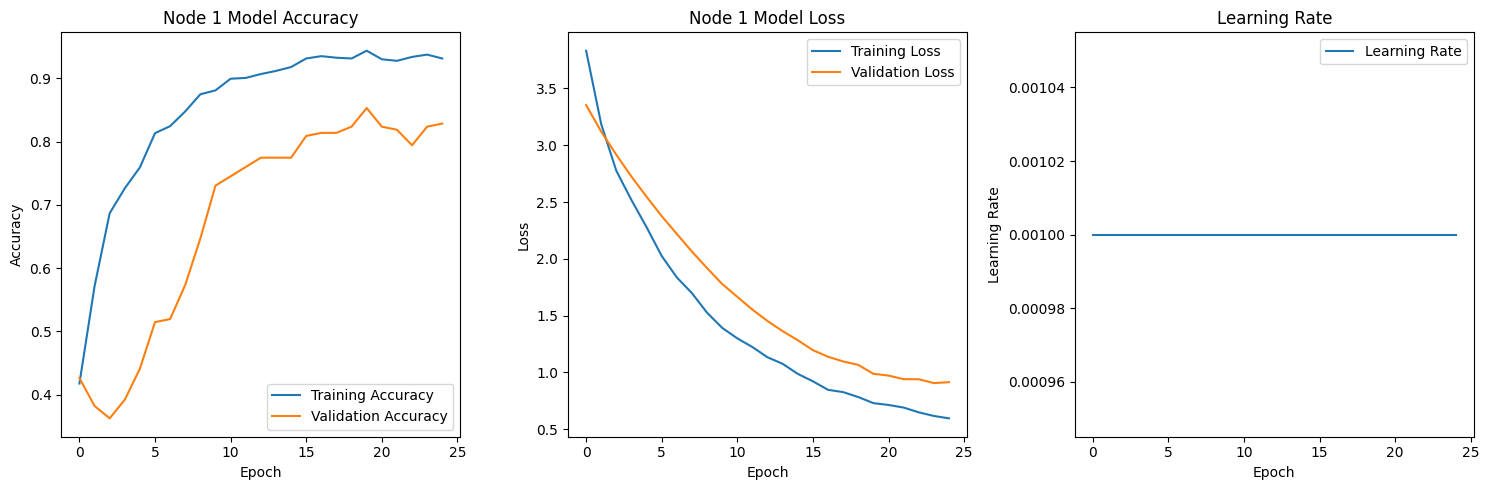


Node 1 Final Results:
Training Accuracy: 0.9435
Validation Accuracy: 0.8529
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8281 - loss: 0.9310 
Test Accuracy: 0.8235


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Node 1 Classification Report:
              precision    recall  f1-score   support

          ai       0.89      0.77      0.82        81
       music       0.81      0.90      0.85        88
        web3       0.78      0.80      0.79        86

    accuracy                           0.82       255
   macro avg       0.83      0.82      0.82       255
weighted avg       0.83      0.82      0.82       255



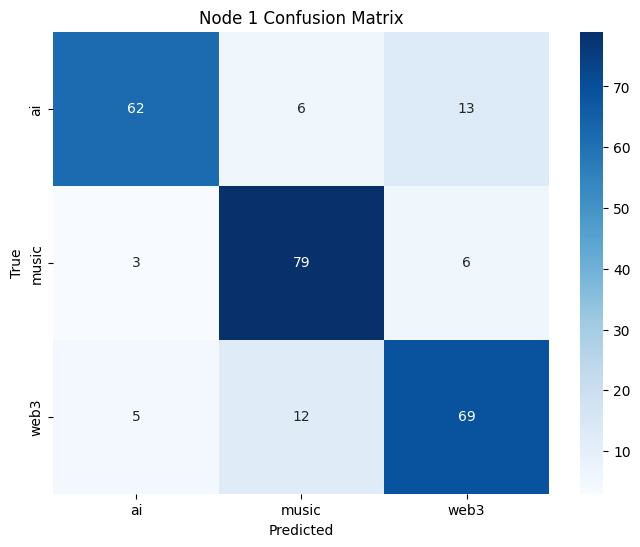


Training Node 2
Node 2 (EU) Dataset Overview:
Total samples: 879

Category distribution:
category
web3     338
music    287
ai       254
Name: count, dtype: int64

Node 2 Training Data:
Training data shape: (703, 305)
Testing data shape: (176, 305)
Class weights: {0: 1.154351395730706, 1: 1.018840579710145, 2: 0.8679012345679012}
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4130 - loss: 4.0340 - val_accuracy: 0.3333 - val_loss: 3.4468 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5108 - loss: 3.4157 - val_accuracy: 0.4255 - val_loss: 3.2388 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5865 - loss: 3.0586 - val_accuracy: 0.5319 - val_loss: 3.0672 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6551 - loss: 2.7408 - val_accuracy: 0.5461 - val_loss: 2.9174 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0

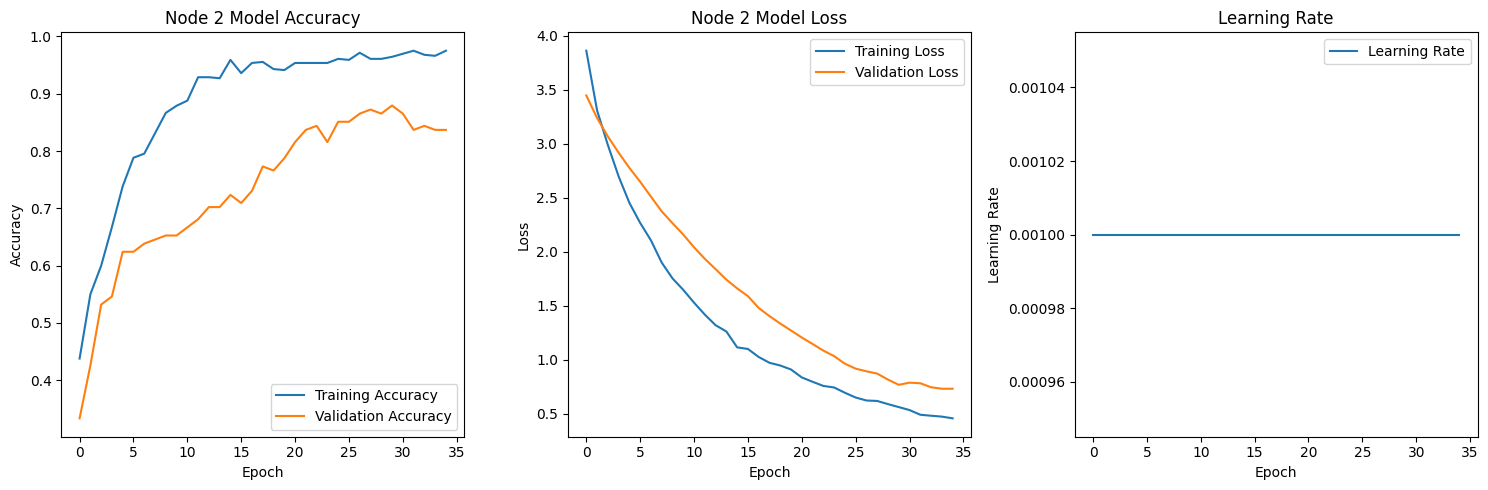


Node 2 Final Results:
Training Accuracy: 0.9751
Validation Accuracy: 0.8794
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8334 - loss: 0.8122 
Test Accuracy: 0.8409
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Node 2 Classification Report:
              precision    recall  f1-score   support

          ai       0.90      0.73      0.80        51
       music       0.77      0.89      0.83        57
        web3       0.87      0.88      0.88        68

    accuracy                           0.84       176
   macro avg       0.85      0.83      0.84       176
weighted avg       0.85      0.84      0.84       176



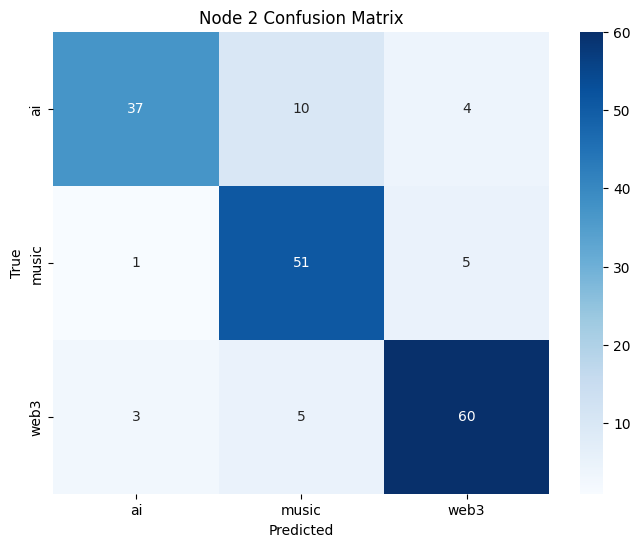


Training Node 3
Node 3 (ASIA) Dataset Overview:
Total samples: 776

Category distribution:
category
ai       271
music    271
web3     234
Name: count, dtype: int64

Node 3 Training Data:
Training data shape: (620, 305)
Testing data shape: (156, 305)
Class weights: {0: 0.9523809523809523, 1: 0.9567901234567902, 2: 1.1051693404634582}
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3894 - loss: 4.1221 - val_accuracy: 0.5242 - val_loss: 3.4205 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5073 - loss: 3.4260 - val_accuracy: 0.5161 - val_loss: 3.2405 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6548 - loss: 3.0305 - val_accuracy: 0.4839 - val_loss: 3.0850 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6778 - loss: 2.7728 - val_accuracy: 0.4839 - val_loss: 2.9425 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy

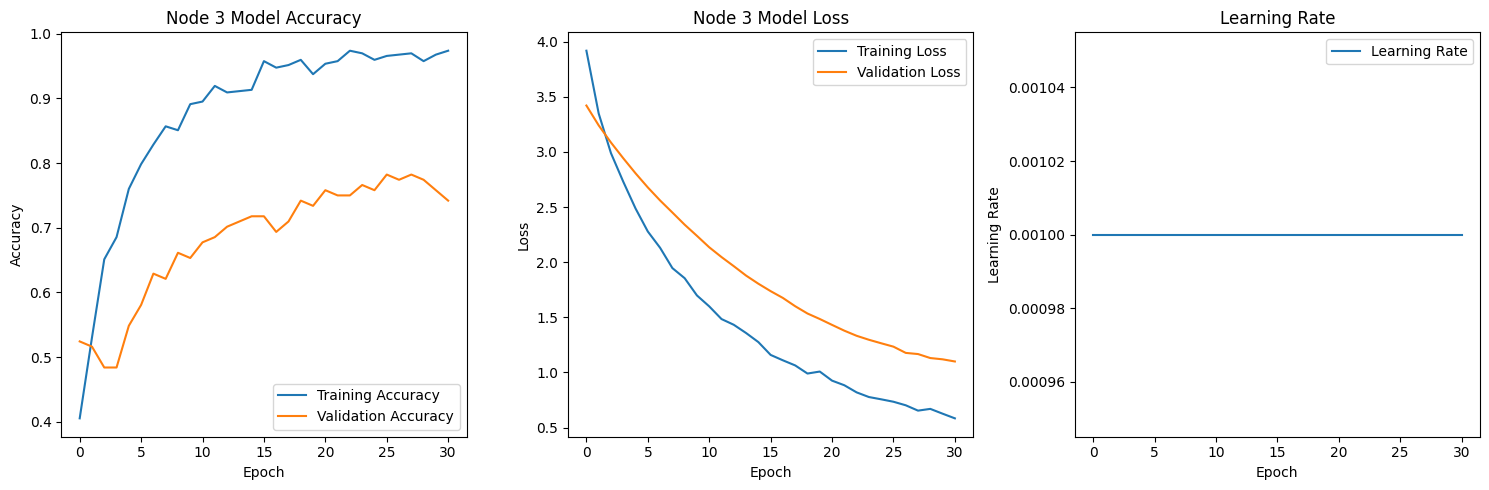


Node 3 Final Results:
Training Accuracy: 0.9738
Validation Accuracy: 0.7823
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 1.0611 
Test Accuracy: 0.8333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Node 3 Classification Report:
              precision    recall  f1-score   support

          ai       0.85      0.81      0.83        54
       music       0.75      0.93      0.83        55
        web3       0.97      0.74      0.84        47

    accuracy                           0.83       156
   macro avg       0.86      0.83      0.83       156
weighted avg       0.85      0.83      0.83       156



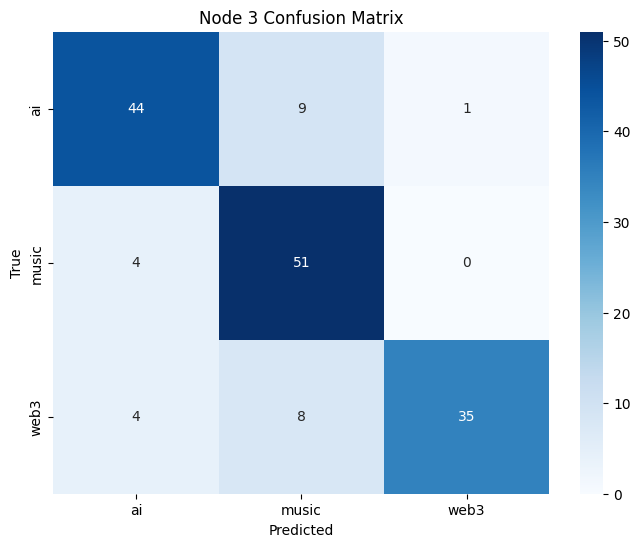

In [2]:
# Cell 1: Initial Setup and Imports
%cd /content
!rm -rf *  # Remove everything first
!git clone https://github.com/muhammmad-al/decentralized-ai-content-recommender.git
%cd decentralized-ai-content-recommender

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import logging
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

def preprocess_text(text):
    """Basic text preprocessing"""
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = ' '.join(text.split())
    return text

def load_node_data(node_number):
    """Load geographically distributed data for each node"""
    # Load all datasets
    datasets = {
        'ai': pd.read_csv('data/raw/reddit_analysis_ai_with_sentiment.csv'),
        'music': pd.read_csv('data/raw/reddit_analysis_music_with_sentiment.csv'),
        'web3': pd.read_csv('data/raw/reddit_analysis_web3_with_sentiment.csv')
    }

    # Convert UTC timestamp to datetime
    for df in datasets.values():
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour_utc'] = df['timestamp'].dt.hour

    # Define geographic distribution based on UTC posting times
    def assign_region(hour):
        if 2 <= hour < 10:     # Peak EU posting hours (UTC)
            return 'EU'
        elif 10 <= hour < 18:   # Peak NA posting hours (UTC)
            return 'NA'
        else:                   # Peak Asia/Pacific posting hours (UTC)
            return 'ASIA'

    # Assign posts to regions
    region_map = {1: 'NA', 2: 'EU', 3: 'ASIA'}
    target_region = region_map[node_number]

    # Filter data for each node's region
    balanced_dfs = []
    for category, df in datasets.items():
        df['region'] = df['hour_utc'].apply(assign_region)
        regional_df = df[df['region'] == target_region].copy()
        regional_df['category'] = category
        balanced_dfs.append(regional_df)

    # Combine datasets
    df = pd.concat(balanced_dfs, ignore_index=True)

    # Text preprocessing
    df['cleaned_title'] = df['title'].apply(preprocess_text)
    df['cleaned_content'] = df['cleaned_text'].apply(preprocess_text)
    df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_content']

    # Create derived features
    df['score_log'] = np.log1p(df['score'])
    df['comments_log'] = np.log1p(df['num_comments'])
    df['text_word_count'] = df['combined_text'].str.split().str.len()

    # Sentiment features
    df['sentiment_compound'] = (df['textblob_sentiment'] + df['transformer_score']) / 2
    df['sentiment_magnitude'] = abs(df['textblob_sentiment'])

    # Normalize numerical features
    numerical_cols = ['score_log', 'comments_log', 'text_word_count',
                     'sentiment_compound', 'sentiment_magnitude']

    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Print node info
    print(f"Node {node_number} ({target_region}) Dataset Overview:")
    print(f"Total samples: {len(df)}")
    print("\nCategory distribution:")
    print(df['category'].value_counts())
    return df

class NodeClient:
    def __init__(self, df, node_number):
        """Initialize node client with dataset"""
        self.df = df
        self.node_number = node_number
        self.prepare_data()
        self.model = self.create_model()

    def prepare_data(self):
        """Prepare features and labels"""
        # Create text features
        self.vectorizer = TfidfVectorizer(
            max_features=300,
            stop_words='english',
            ngram_range=(1, 1),
            min_df=2,
            max_df=0.95
        )
        X_text = self.vectorizer.fit_transform(self.df['combined_text']).toarray()

        # Add numerical features
        numerical_features = ['score_log', 'comments_log', 'text_word_count',
                            'sentiment_compound', 'sentiment_magnitude']
        X_numerical = self.df[numerical_features].fillna(0).values

        # Combine features
        self.X = np.hstack([X_text, X_numerical])

        # Prepare labels
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.df['category'])

        # Split data with stratification
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, test_size=0.2,
                           stratify=self.y,
                           random_state=42+self.node_number)

        # Compute class weights
        self.class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        self.class_weights = dict(enumerate(self.class_weights))

        print(f"\nNode {self.node_number} Training Data:")
        print(f"Training data shape: {self.X_train.shape}")
        print(f"Testing data shape: {self.X_test.shape}")
        print("Class weights:", self.class_weights)

    def create_model(self):
        """Create neural network model"""
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu',
                                input_shape=(self.X_train.shape[1],),
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(64, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(3, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

def train_and_evaluate_node(node_number):
    """Train and evaluate a single node"""
    # Load data
    node_df = load_node_data(node_number)

    # Initialize client
    node = NodeClient(node_df, node_number)

    # Train
    history = node.model.fit(
        node.X_train,
        node.y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        class_weight=node.class_weights,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True,
                min_delta=0.005
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=0.0001
            )
        ],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Node {node_number} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Node {node_number} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['learning_rate'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final evaluation
    print(f"\nNode {node_number} Final Results:")
    print(f"Training Accuracy: {max(history.history['accuracy']):.4f}")
    print(f"Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

    test_loss, test_accuracy = node.model.evaluate(node.X_test, node.y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    y_pred = node.model.predict(node.X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(f"\nNode {node_number} Classification Report:")
    print(classification_report(node.y_test, y_pred_classes,
                              target_names=node.label_encoder.classes_))

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(node.y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=node.label_encoder.classes_,
                yticklabels=node.label_encoder.classes_)
    plt.title(f'Node {node_number} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return node

def main():
    """Train all three nodes"""
    # Train each node
    for node_number in [1, 2, 3]:
        print(f"\nTraining Node {node_number}")
        print("=" * 50)
        node = train_and_evaluate_node(node_number)

if __name__ == "__main__":
    main()